# 基于双分量波函数的速度场超分辨率算法研究

# 传统超分辨算法

在问题研究初期，我们首先进行最简单的研究，我们暂时不考虑复杂流场而是考虑进行构造简单的流场来测试我们的模型具有一定的研究价值

In [20]:
# 导入必须的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt


In [41]:
# 创建一个简单的数据集
class VelocityFieldDataset(Dataset):
    def __init__(self, low_res_data, high_res_data):
        self.low_res_data = low_res_data
        self.high_res_data = high_res_data

    def __len__(self):
        return len(self.low_res_data)

    def __getitem__(self, idx):
        return (self.low_res_data[idx], self.high_res_data[idx])


In [31]:
def generate_vortex_field(size, num_vortices):
    """生成具有指定数量涡旋的速度场"""
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    U = np.zeros_like(X)
    V = np.zeros_like(Y)

    for _ in range(num_vortices):
        x_center = np.random.uniform(-0.5, 0.5)
        y_center = np.random.uniform(-0.5, 0.5)
        strength = np.random.uniform(0.5, 1.5)

        u = -strength * (Y - y_center) * np.exp(-((X - x_center)**2 + (Y - y_center)**2))
        v = strength * (X - x_center) * np.exp(-((X - x_center)**2 + (Y - y_center)**2))

        U += u
        V += v

    return U, V

In [36]:
def create_velocity_field_data(low_res_size, high_res_size, num_samples):
    low_res_data = []
    high_res_data = []

    for _ in range(num_samples):
        U_low, V_low = generate_vortex_field(low_res_size, num_vortices=5)
        U_high, V_high = generate_vortex_field(high_res_size, num_vortices=5)

        low_res_velocity = np.sqrt(U_low**2 + V_low**2)
        high_res_velocity = np.sqrt(U_high**2 + V_high**2)

        low_res_data.append(low_res_velocity)
        high_res_data.append(high_res_velocity)

    low_res_data = np.expand_dims(np.array(low_res_data), axis=1)
    high_res_data = np.expand_dims(np.array(high_res_data), axis=1)

    return low_res_data, high_res_data


In [37]:
# 定义一个简单的超分辨率CNN模型
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)   # 1x16x16 -> 64x16x16
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)  # 64x16x16 -> 32x16x16
        self.upsample = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=4, padding=0)  # 32x16x16 -> 32x64x64
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)  # 32x64x64 -> 1x64x64

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.upsample(x)  # 上采样至更高分辨率
        x = self.conv3(x)
        return x



In [38]:
low_res_data, high_res_data = create_velocity_field_data(16, 64, 100)


In [39]:
low_res_data.shape, high_res_data.shape

((100, 1, 16, 16), (100, 1, 64, 64))

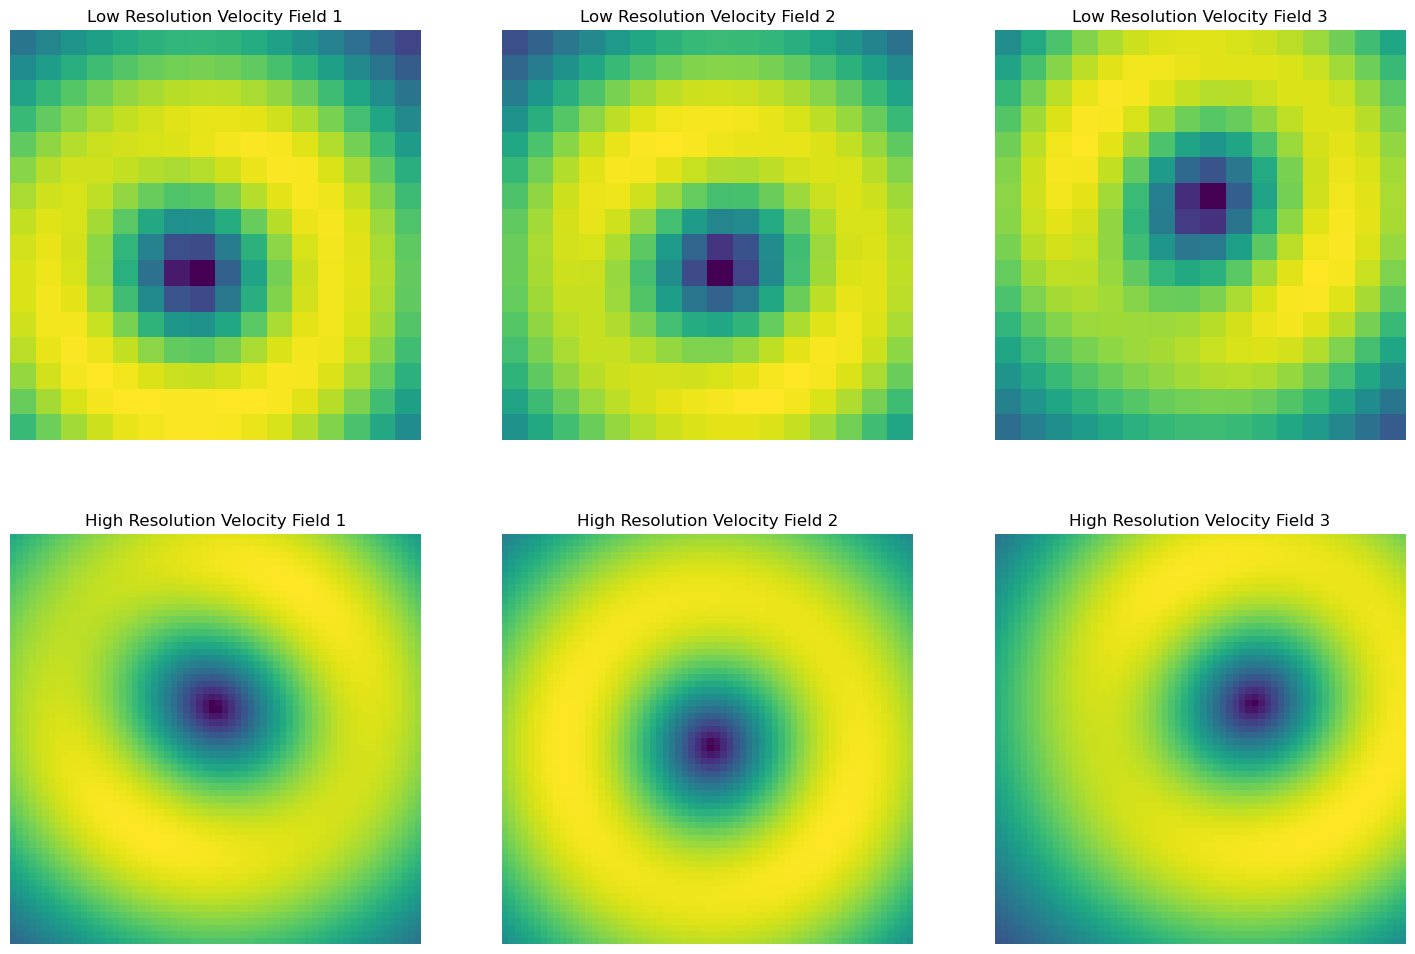

In [40]:
# 可视化低分辨率和高分辨率的速度场
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

for i in range(3):
    axs[0, i].imshow(low_res_data[i][0], cmap='viridis', interpolation='nearest')
    axs[0, i].set_title(f'Low Resolution Velocity Field {i+1}')
    axs[0, i].axis('off')

    axs[1, i].imshow(high_res_data[i][0], cmap='viridis', interpolation='nearest')
    axs[1, i].set_title(f'High Resolution Velocity Field {i+1}')
    axs[1, i].axis('off')

plt.show()

In [48]:
# 创建数据加载器
dataset = VelocityFieldDataset(low_res_data, high_res_data)
dataloader = DataLoader(dataset, batch_size=30, shuffle=True)


In [49]:
model = SRCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [54]:
num_epochs = 1000
for epoch in range(num_epochs):
    for batch in dataloader:
        low_res, high_res = batch
        low_res, high_res = torch.tensor(low_res).float(), torch.tensor(high_res).float()  # 确保输入是float32类型

        # 前向传播
        outputs = model(low_res)
        loss = criterion(outputs, high_res)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("训练完成！")

C:\Users\user\AppData\Local\Temp\ipykernel_37912\3305316508.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  low_res, high_res = torch.tensor(low_res).float(), torch.tensor(high_res).float()  # 确保输入是float32类型


Epoch [1/1000], Loss: 0.0838
Epoch [2/1000], Loss: 0.0893
Epoch [3/1000], Loss: 0.0936
Epoch [4/1000], Loss: 0.0704
Epoch [5/1000], Loss: 0.1061
Epoch [6/1000], Loss: 0.0772
Epoch [7/1000], Loss: 0.1264
Epoch [8/1000], Loss: 0.0824
Epoch [9/1000], Loss: 0.1154
Epoch [10/1000], Loss: 0.0585
Epoch [11/1000], Loss: 0.1308
Epoch [12/1000], Loss: 0.0963
Epoch [13/1000], Loss: 0.0777
Epoch [14/1000], Loss: 0.1145
Epoch [15/1000], Loss: 0.0918
Epoch [16/1000], Loss: 0.1081
Epoch [17/1000], Loss: 0.0936
Epoch [18/1000], Loss: 0.1238
Epoch [19/1000], Loss: 0.0882
Epoch [20/1000], Loss: 0.0773
Epoch [21/1000], Loss: 0.1331
Epoch [22/1000], Loss: 0.1284
Epoch [23/1000], Loss: 0.0928
Epoch [24/1000], Loss: 0.1101
Epoch [25/1000], Loss: 0.1475
Epoch [26/1000], Loss: 0.1155
Epoch [27/1000], Loss: 0.0706
Epoch [28/1000], Loss: 0.1008
Epoch [29/1000], Loss: 0.1283
Epoch [30/1000], Loss: 0.0900
Epoch [31/1000], Loss: 0.1080
Epoch [32/1000], Loss: 0.1049
Epoch [33/1000], Loss: 0.0909
Epoch [34/1000], Lo

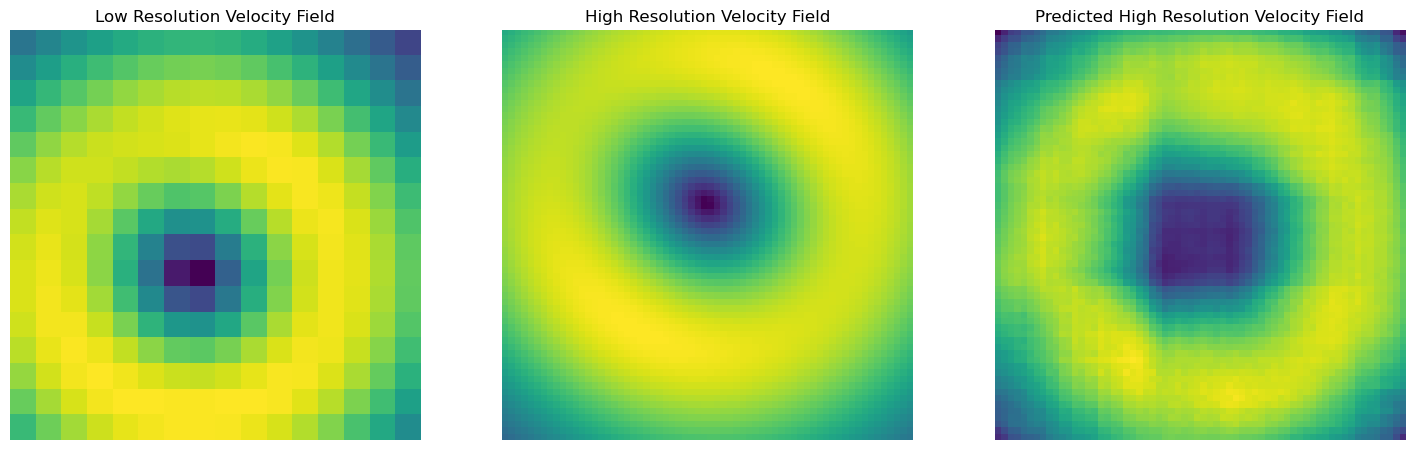

In [55]:
# 可视化对比结果
test_low_res = low_res_data[0]  # 随机选择一个测试样本
test_high_res = high_res_data[0]  # 对应的高分辨率样本

with torch.no_grad():
    model.eval()
    test_output = model(torch.tensor(test_low_res).unsqueeze(0).float())

# 显示低分辨率、高分辨率和预测的高分辨率图像
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(test_low_res[0], cmap='viridis', interpolation='nearest')
axs[0].set_title('Low Resolution Velocity Field')
axs[0].axis('off')

axs[1].imshow(test_high_res[0], cmap='viridis', interpolation='nearest')
axs[1].set_title('High Resolution Velocity Field')
axs[1].axis('off')

axs[2].imshow(test_output.squeeze().numpy(), cmap='viridis', interpolation='nearest')
axs[2].set_title('Predicted High Resolution Velocity Field')
axs[2].axis('off')

plt.show()

In [53]:
test_output.squeeze().numpy().shape,test_high_res[0].shape

((64, 64), (64, 64))

# 深度学习超分辨算法

## 双分量波函数


在我们的论文中，我们首先构造较为简单的一维算例

$$
a(x,t) = sin(x - t)\\
b(x,t) = cos(x + t)\\
c(x,t) = sin(x + t)\\
d(x,t) = cos(x - t)\\
$$

$$
x\in(-\pi, \pi)\\
t\in(0, 10)\\
\bar h=1
$$
因此，双分量波函数可以表示为如下形式
$$
\mathbf{\psi}=[\psi_1, \psi_2]^T=[sin(x - t)+icos(x + t), sin(x + t)+icos(x - t)]^T
$$

### 波函数转到速度场

我们采用symph库进行计算

In [60]:
import sympy as sp
from sympy.algebras.quaternion import Quaternion

x, t = sp.symbols('x t')
# 定义符号变量
a = sp.sin(x - t)
b = sp.cos(x + t)
c = sp.sin(x + t)
d = sp.cos(x - t)

# 求导
a_x = sp.diff(a, x)
b_x = sp.diff(b, x)
c_x = sp.diff(c, x)
d_x = sp.diff(d, x)



u=(a*b_x - b*a_x + c*d_x - d*c_x)
u

2*sin(t - x)*sin(t + x) - 2*cos(t - x)*cos(t + x)

我们可以计算出该波函数下的速度场为:
$2sin(t-x)sin(t+x)-2cos(t-x)cos(t+x)$

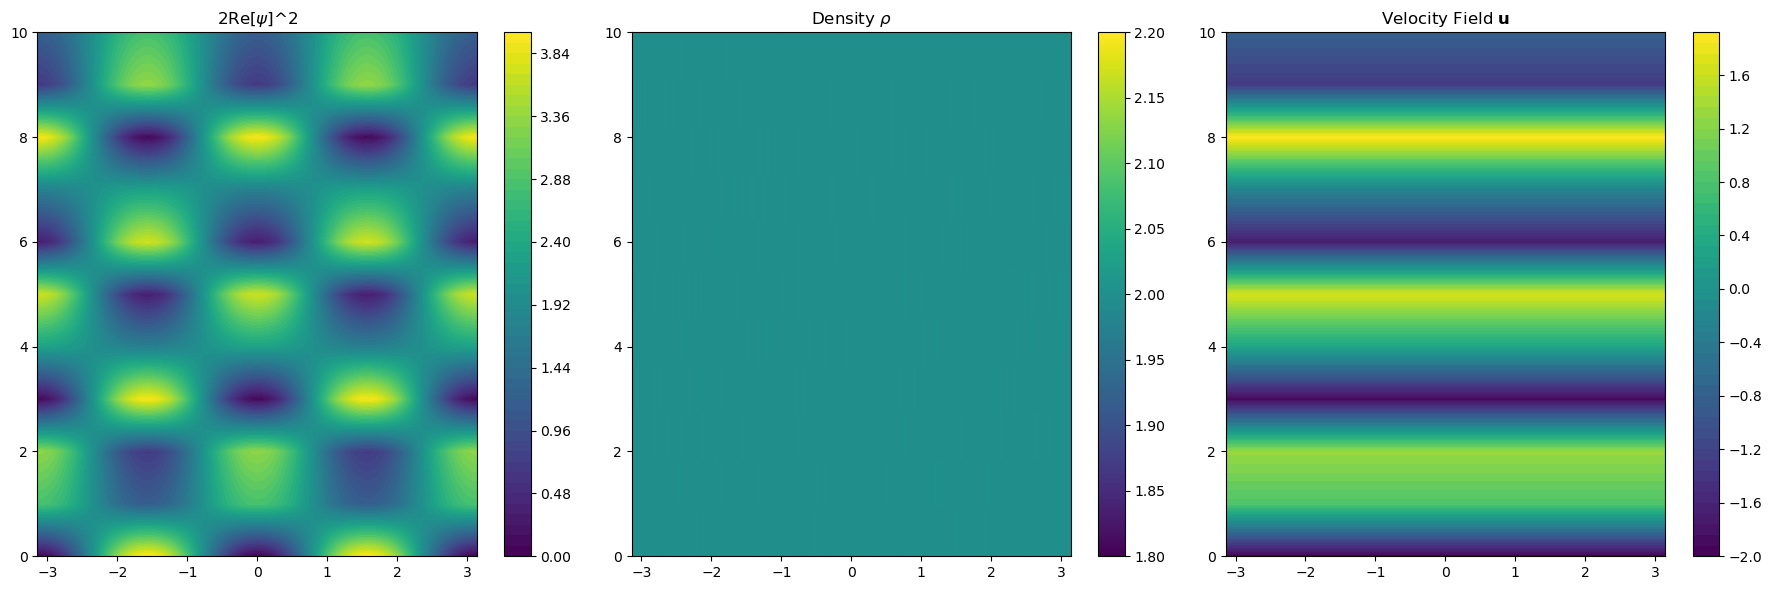

In [86]:
# 定义空间和时间的范围
x = np.linspace(-np.pi, np.pi, 400)
t = np.linspace(0, 10, 11)
X, T = np.meshgrid(x, t)

# 定义波函数分量
psi1 = np.sin(X - T) + 1j * np.cos(X + T)
psi2 = np.sin(X + T) + 1j * np.cos(X - T)

# 计算2Re[\psi]^2
re_psi_sq = 2 * (np.real(psi1)**2 + np.real(psi2)**2)

# 计算密度ρ=|ψ|^2
rho = np.abs(psi1)**2 + np.abs(psi2)**2

# 计算速度场
u = 2 * np.sin(T - X) * np.sin(T + X) - 2 * np.cos(T - X) * np.cos(T + X)

# 绘图
plt.figure(figsize=(18, 6))

# 绘制2Re[\psi]^2
plt.subplot(1, 3, 1)
plt.contourf(X, T, re_psi_sq, levels=50, cmap='viridis')
plt.colorbar()
plt.title('2Re[$\psi$]^2')

# 绘制密度ρ
plt.subplot(1, 3, 2)
plt.imshow(rho, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')

plt.colorbar()
plt.title('Density $\\rho$')

# 绘制速度场
plt.subplot(1, 3, 3)
plt.contourf(X, T, u, levels=50, cmap='viridis')
plt.colorbar()
plt.title('Velocity Field $\\mathbf{u}$')

plt.tight_layout()
plt.show()

In [72]:
rho

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

In [76]:
rho1=np.sin(X - T)**2 + np.cos(X + T)**2 + np.sin(X + T)**2 + np.cos(X - T)**2
rho1.shape,x.shape

((400, 400), (400,))

In [80]:
rho1 = np.full((400, 400), 2)  # 假设所有元素都是2

# 检查所有元素是否等于2
all_equal_two = np.all(rho1 == 2)

print("Are all elements in rho1 equal to 2?", all_equal_two)

Are all elements in rho1 equal to 2? True


### 速度场转波函数

#### 随机梯度算法


In [137]:
# 只能得到abcd的值，无法得到速度场u的值
import torch
import torch.optim as optim
import numpy as np

# 定义模型参数
a = torch.randn((), requires_grad=True)
b = torch.randn((), requires_grad=True)
c = torch.randn((), requires_grad=True)
d = torch.randn((), requires_grad=True)

# 定义时间和空间变量，确保它们不需要梯度
x = torch.linspace(-np.pi, np.pi, 400, requires_grad=False)
t = torch.linspace(0, 10, 400, requires_grad=False)
X, T = torch.meshgrid(x, t, indexing='ij')

# 符号表达式对应的PyTorch表达式计算速度场
def compute_velocity(X, T, a, b, c, d):
    a_val = a * torch.sin(X - T)
    b_val = b * torch.cos(X + T)
    c_val = c * torch.sin(X + T)
    d_val = d * torch.cos(X - T)
    a_x = a * torch.cos(X - T) * (-1)
    b_x = b * torch.sin(X + T)
    c_x = c * torch.cos(X + T)
    d_x = d * torch.sin(X - T) * (-1)
    return a_val * b_x - b_val * a_x + c_val * d_x - d_val * c_x

# 目标速度场，这里使用前面部分你计算出的速度场作为目标
u_target = 2 * torch.sin(T - X) * torch.sin(T + X) - 2 * torch.cos(T - X) * torch.cos(T + X)

# 优化器
optimizer = optim.Adam([a, b, c, d], lr=0.01)

# 优化循环
for epoch in range(1000):
    optimizer.zero_grad()
    u_pred = compute_velocity(X, T, a, b, c, d)
    loss = (u_pred - u_target).pow(2).mean()
    
    # 打印中间结果，检查 requires_grad 属性
    print(f"Epoch {epoch}: a={a.item()}, b={b.item()}, c={c.item()}, d={d.item()}")
    print(f"u_pred requires_grad: {u_pred.requires_grad}")
    print(f"loss requires_grad: {loss.requires_grad}")
    
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# 打印优化后的参数
print(f'Optimized parameters: a={a.item()}, b={b.item()}, c={c.item()}, d={d.item()}')


Epoch 0: a=1.2569142580032349, b=-2.019582986831665, c=-2.8155064582824707, d=0.09231587499380112
u_pred requires_grad: True
loss requires_grad: True
Epoch 0, Loss: 0.03952484577894211
Epoch 1: a=1.246914267539978, b=-2.009582996368408, c=-2.8255064487457275, d=0.10231587290763855
u_pred requires_grad: True
loss requires_grad: True
Epoch 2: a=1.2370601892471313, b=-1.9997315406799316, c=-2.8354406356811523, d=0.11217718571424484
u_pred requires_grad: True
loss requires_grad: True
Epoch 3: a=1.2275197505950928, b=-1.990198016166687, c=-2.8451924324035645, d=0.1217368096113205
u_pred requires_grad: True
loss requires_grad: True
Epoch 4: a=1.2185357809066772, b=-1.9812257289886475, c=-2.8545384407043457, d=0.13075333833694458
u_pred requires_grad: True
loss requires_grad: True
Epoch 5: a=1.2104299068450928, b=-1.9731340408325195, c=-2.863093614578247, d=0.13889911770820618
u_pred requires_grad: True
loss requires_grad: True
Epoch 6: a=1.2035653591156006, b=-1.9662803411483765, c=-2.870294

In [95]:
#能得到场
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 定义多项式模型参数
coeffs_a = torch.randn(3, requires_grad=True)
coeffs_b = torch.randn(3, requires_grad=True)
coeffs_c = torch.randn(3, requires_grad=True)
coeffs_d = torch.randn(3, requires_grad=True)

# 定义时间和空间变量，确保它们不需要梯度
x = torch.linspace(-np.pi, np.pi, 400)
t = torch.linspace(0, 10, 400)
X, T = torch.meshgrid(x, t, indexing='ij')

# 定义多项式函数
def poly(x, t, coeffs):
    return coeffs[0] + coeffs[1] * x + coeffs[2] * t

# 计算速度场
def compute_velocity(X, T, coeffs_a, coeffs_b, coeffs_c, coeffs_d):
    a_val = poly(X, T, coeffs_a) * torch.sin(X - T)
    b_val = poly(X, T, coeffs_b) * torch.cos(X + T)
    c_val = poly(X, T, coeffs_c) * torch.sin(X + T)
    d_val = poly(X, T, coeffs_d) * torch.cos(X - T)
    a_x = poly(X, T, coeffs_a) * torch.cos(X - T) * (-1)
    b_x = poly(X, T, coeffs_b) * torch.sin(X + T)
    c_x = poly(X, T, coeffs_c) * torch.cos(X + T)
    d_x = poly(X, T, coeffs_d) * torch.sin(X - T) * (-1)
    return a_val * b_x - b_val * a_x + c_val * d_x - d_val * c_x

# 目标速度场，这里使用前面部分你计算出的速度场作为目标
u_target = 2 * torch.sin(T - X) * torch.sin(T + X) - 2 * torch.cos(T - X) * torch.cos(T + X)

# 优化器
optimizer = optim.Adam([coeffs_a, coeffs_b, coeffs_c, coeffs_d], lr=0.01)

# 优化循环
for epoch in range(10000):
    optimizer.zero_grad()
    u_pred = compute_velocity(X, T, coeffs_a, coeffs_b, coeffs_c, coeffs_d)
    loss = (u_pred - u_target).pow(2).mean()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# 打印优化后的参数
print(f'Optimized coefficients:')
print(f'coeffs_a={coeffs_a.detach().numpy()}')
print(f'coeffs_b={coeffs_b.detach().numpy()}')
print(f'coeffs_c={coeffs_c.detach().numpy()}')
print(f'coeffs_d={coeffs_d.detach().numpy()}')

# 测试模型
u_pred_test = compute_velocity(X, T, coeffs_a, coeffs_b, coeffs_c, coeffs_d)
test_loss = (u_pred_test - u_target).pow(2).mean().item()
print(f'Test Loss: {test_loss}')



Epoch 0, Loss: 1048.3560791015625
Epoch 100, Loss: 9.119378089904785
Epoch 200, Loss: 1.8427822589874268
Epoch 300, Loss: 0.6058176755905151
Epoch 400, Loss: 0.41936054825782776
Epoch 500, Loss: 0.37961626052856445
Epoch 600, Loss: 0.3554745018482208
Epoch 700, Loss: 0.3358071744441986
Epoch 800, Loss: 0.3196600079536438
Epoch 900, Loss: 0.30637848377227783
Epoch 1000, Loss: 0.2952747344970703
Epoch 1100, Loss: 0.28573212027549744
Epoch 1200, Loss: 0.2772618532180786
Epoch 1300, Loss: 0.26951318979263306
Epoch 1400, Loss: 0.2622559368610382
Epoch 1500, Loss: 0.2553507685661316
Epoch 1600, Loss: 0.24871833622455597
Epoch 1700, Loss: 0.2423136681318283
Epoch 1800, Loss: 0.2361084520816803
Epoch 1900, Loss: 0.23007993400096893
Epoch 2000, Loss: 0.22420626878738403
Epoch 2100, Loss: 0.21846450865268707
Epoch 2200, Loss: 0.21283169090747833
Epoch 2300, Loss: 0.20728632807731628
Epoch 2400, Loss: 0.20180976390838623
Epoch 2500, Loss: 0.19638745486736298
Epoch 2600, Loss: 0.19100908935070038


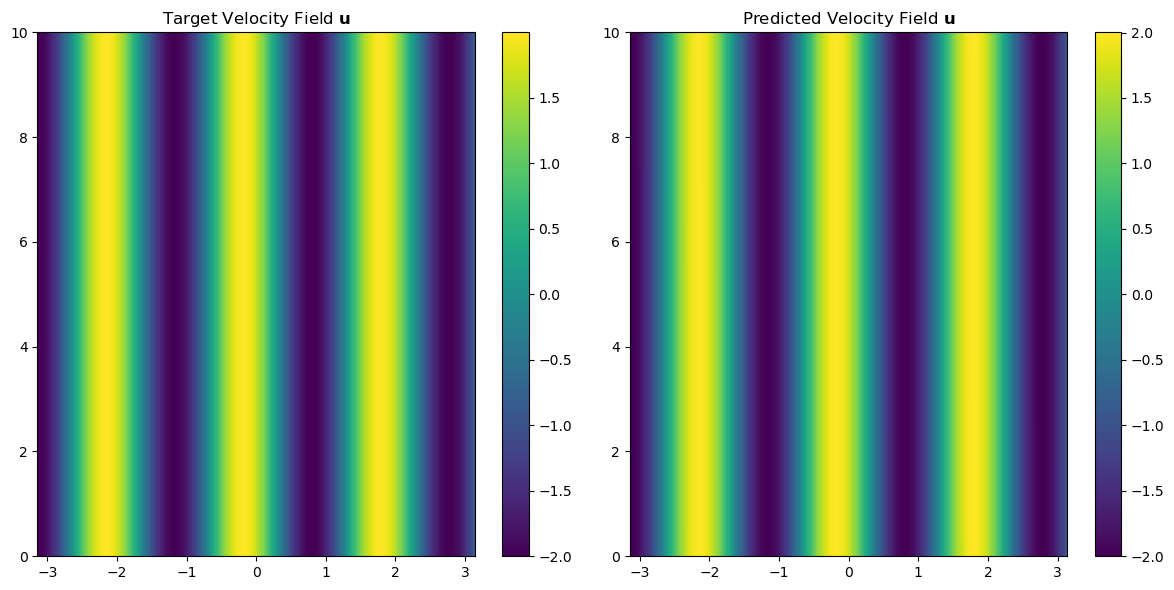

In [109]:

# 绘图
plt.figure(figsize=(12, 6))

# 绘制目标速度场
plt.subplot(1, 2, 1)
# plt.contourf(X, T, u_target.detach().numpy(), levels=50, cmap='viridis')
plt.imshow(u_target.detach().numpy(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Target Velocity Field $\\mathbf{u}$')

# 绘制预测速度场
plt.subplot(1, 2, 2)
# plt.contourf(X, T, u_pred_test.detach().numpy(), levels=50, cmap='viridis')
plt.imshow(u_pred_test.detach().numpy(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Predicted Velocity Field $\\mathbf{u}$')

plt.tight_layout()
plt.show()

Epoch 0, Loss: 787.8096313476562
Epoch 100, Loss: 1.5268193483352661
Epoch 200, Loss: 1.1795804500579834
Epoch 300, Loss: 0.8805269598960876
Epoch 400, Loss: 0.661261260509491
Epoch 500, Loss: 0.514117956161499
Epoch 600, Loss: 0.4198525846004486
Epoch 700, Loss: 0.3603544533252716
Epoch 800, Loss: 0.322433739900589
Epoch 900, Loss: 0.29752567410469055
Epoch 1000, Loss: 0.2803192138671875
Epoch 1100, Loss: 0.26756832003593445
Epoch 1200, Loss: 0.2573213279247284
Epoch 1300, Loss: 0.24844272434711456
Epoch 1400, Loss: 0.24030859768390656
Epoch 1500, Loss: 0.23260340094566345
Epoch 1600, Loss: 0.22518664598464966
Epoch 1700, Loss: 0.21801015734672546
Epoch 1800, Loss: 0.21106967329978943
Epoch 1900, Loss: 0.20437800884246826
Epoch 2000, Loss: 0.1979520320892334
Epoch 2100, Loss: 0.19180366396903992
Epoch 2200, Loss: 0.18593621253967285
Epoch 2300, Loss: 0.180342897772789
Epoch 2400, Loss: 0.17500673234462738
Epoch 2500, Loss: 0.16990244388580322
Epoch 2600, Loss: 0.16499905288219452
Epoc

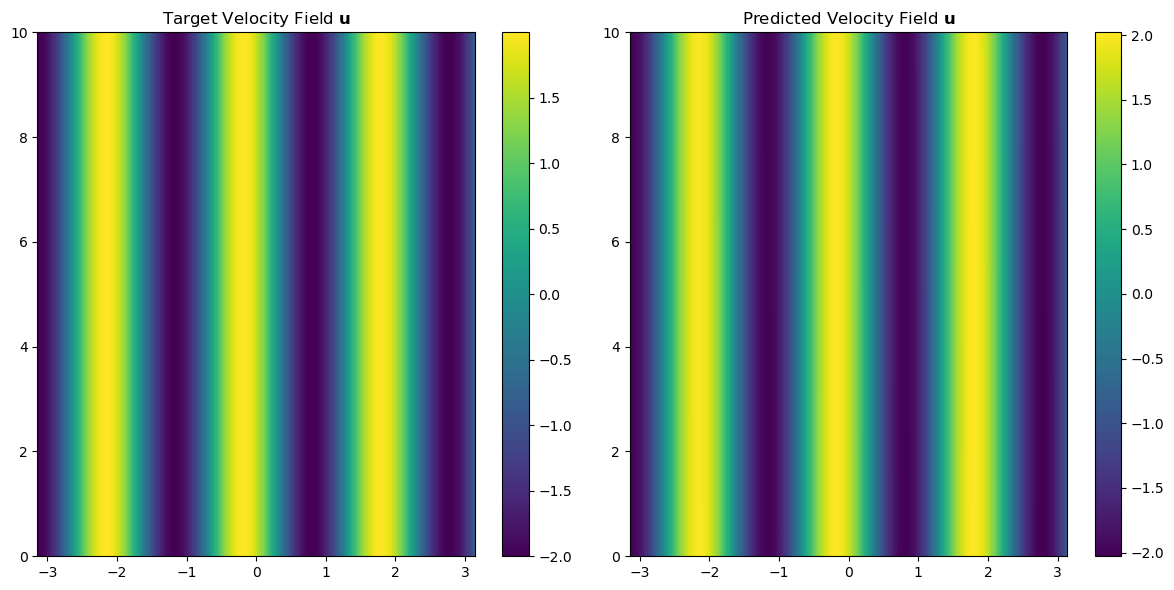

In [138]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 定义多项式模型参数
coeffs_a = torch.randn(3, requires_grad=True)
coeffs_b = torch.randn(3, requires_grad=True)
coeffs_c = torch.randn(3, requires_grad=True)
coeffs_d = torch.randn(3, requires_grad=True)

# 定义时间和空间变量，确保它们不需要梯度
x = torch.linspace(-np.pi, np.pi, 400)
t = torch.linspace(0, 10, 400)
X, T = torch.meshgrid(x, t, indexing='ij')

# 定义多项式函数
def poly(x, t, coeffs):
    return coeffs[0] + coeffs[1] * x + coeffs[2] * t

# 计算速度场
def compute_velocity(X, T, coeffs_a, coeffs_b, coeffs_c, coeffs_d):
    a_val = poly(X, T, coeffs_a) * torch.sin(X - T)
    b_val = poly(X, T, coeffs_b) * torch.cos(X + T)
    c_val = poly(X, T, coeffs_c) * torch.sin(X + T)
    d_val = poly(X, T, coeffs_d) * torch.cos(X - T)
    a_x = poly(X, T, coeffs_a) * torch.cos(X - T) * (-1)
    b_x = poly(X, T, coeffs_b) * torch.sin(X + T)
    c_x = poly(X, T, coeffs_c) * torch.cos(X + T)
    d_x = poly(X, T, coeffs_d) * torch.sin(X - T) * (-1)
    return a_val * b_x - b_val * a_x + c_val * d_x - d_val * c_x

# 目标速度场，这里使用前面部分你计算出的速度场作为目标
u_target = 2 * torch.sin(T - X) * torch.sin(T + X) - 2 * torch.cos(T - X) * torch.cos(T + X)

# 优化器
optimizer = optim.Adam([coeffs_a, coeffs_b, coeffs_c, coeffs_d], lr=0.01)

# 优化循环
for epoch in range(10000):
    optimizer.zero_grad()
    u_pred = compute_velocity(X, T, coeffs_a, coeffs_b, coeffs_c, coeffs_d)
    loss = (u_pred - u_target).pow(2).mean()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# 打印优化后的参数
print(f'Optimized coefficients:')
print(f'coeffs_a={coeffs_a.detach().numpy()}')
print(f'coeffs_b={coeffs_b.detach().numpy()}')
print(f'coeffs_c={coeffs_c.detach().numpy()}')
print(f'coeffs_d={coeffs_d.detach().numpy()}')

# 测试模型
u_pred_test = compute_velocity(X, T, coeffs_a, coeffs_b, coeffs_c, coeffs_d)
test_loss = (u_pred_test - u_target).pow(2).mean().item()
print(f'Test Loss: {test_loss}')

# 转换为numpy数组进行计算
u_target_np = u_target.detach().numpy()
u_pred_test_np = u_pred_test.detach().numpy()

# 计算误差指标
mse = mean_squared_error(u_target_np, u_pred_test_np)
mae = mean_absolute_error(u_target_np, u_pred_test_np)
r2 = r2_score(u_target_np, u_pred_test_np)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')

# 绘图
plt.figure(figsize=(12, 6))

# 绘制目标速度场
plt.subplot(1, 2, 1)
plt.imshow(u_target_np, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Target Velocity Field $\\mathbf{u}$')

# 绘制预测速度场
plt.subplot(1, 2, 2)
plt.imshow(u_pred_test_np, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Predicted Velocity Field $\\mathbf{u}$')

plt.tight_layout()
plt.show()


In [99]:
u_target_np.shape,u_pred_test_np.shape

((400, 400), (400, 400))

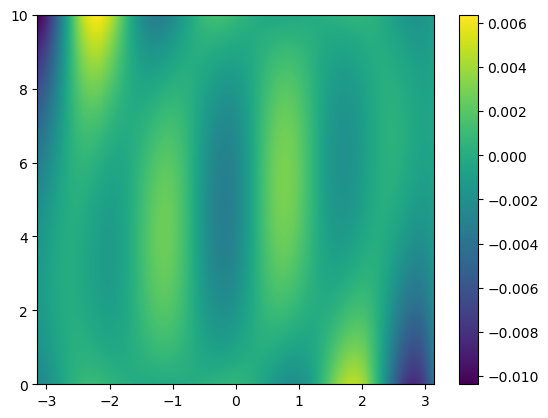

In [101]:
plt.imshow(u_target_np-u_pred_test_np, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
# u_target_np-u_pred_test_np

#### 深度学习算法

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 生成数据
def generate_data(num_samples):
    x = np.linspace(-np.pi, np.pi, 400)
    t = np.linspace(0, 10, 400)
    X, T = np.meshgrid(x, t, indexing='ij')
    data = []
    for _ in range(num_samples):
        a = np.random.randn()
        b = np.random.randn()
        c = np.random.randn()
        d = np.random.randn()
        u = a * np.sin(X - T) * np.cos(X + T) - b * np.cos(X - T) * np.sin(X + T) + c * np.sin(X + T) * np.cos(X - T) - d * np.cos(X + T) * np.sin(X - T)
        data.append(((a, b, c, d), u))
    return data

# 准备训练和测试数据
num_samples = 1000
data = generate_data(num_samples)
train_data = data[:800]
test_data = data[800:]

# 定义数据集和数据加载器
class VelocityDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        params, u = self.data[idx]
        return torch.tensor(params, dtype=torch.float32), torch.tensor(u, dtype=torch.float32)

train_dataset = VelocityDataset(train_data)
test_dataset = VelocityDataset(test_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定义神经网络模型
class VelocityPredictor(nn.Module):
    def __init__(self):
        super(VelocityPredictor, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 400*400)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 400, 400)
        return x

# 初始化模型和优化器
model = VelocityPredictor()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 训练模型
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for params, u in train_loader:
        optimizer.zero_grad()
        outputs = model(params)
        loss = criterion(outputs, u)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')





In [105]:
# 测试模型
model.eval()
with torch.no_grad():
    test_params = []
    test_targets = []
    test_predictions = []
    for params, u in test_loader:
        outputs = model(params)
        test_params.append(params.numpy())
        test_targets.append(u.numpy())
        test_predictions.append(outputs.numpy())

    test_params = np.concatenate(test_params)
    test_targets = np.concatenate(test_targets)
    test_predictions = np.concatenate(test_predictions)

    # 将三维数组展平为一维数组
    test_targets_flat = test_targets.flatten()
    test_predictions_flat = test_predictions.flatten()

    mse = mean_squared_error(test_targets_flat, test_predictions_flat)
    mae = mean_absolute_error(test_targets_flat, test_predictions_flat)
    r2 = r2_score(test_targets_flat, test_predictions_flat)

    print(f'Test Mean Squared Error: {mse}')
    print(f'Test Mean Absolute Error: {mae}')
    print(f'Test R^2 Score: {r2}')


Test Mean Squared Error: 0.0002612774260342121
Test Mean Absolute Error: 0.012282149866223335
Test R^2 Score: 0.9997284412384033


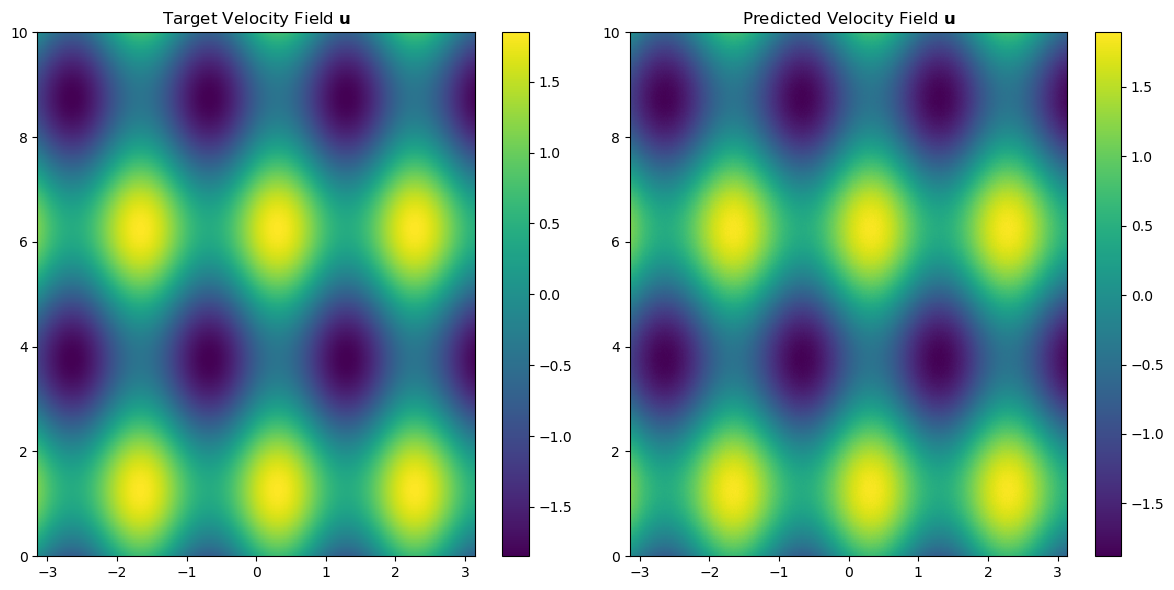

In [106]:
# 可视化结果
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(test_targets[0], extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Target Velocity Field $\\mathbf{u}$')

plt.subplot(1, 2, 2)
plt.imshow(test_predictions[0], extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Predicted Velocity Field $\\mathbf{u}$')

plt.tight_layout()
plt.show()

#### 使用同一组测试集尝试

In [29]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



In [30]:
# 生成数据
def generate_data(num_samples):
    x = np.linspace(-np.pi, np.pi, 400)
    t = np.linspace(0, 10, 400)
    X, T = np.meshgrid(x, t, indexing='ij')
    data = []
    for _ in range(num_samples):
        a = np.random.randn()
        b = np.random.randn()
        c = np.random.randn()
        d = np.random.randn()
        u = a * np.sin(X - T) * np.cos(X + T) - b * np.cos(X - T) * np.sin(X + T) + c * np.sin(X + T) * np.cos(X - T) - d * np.cos(X + T) * np.sin(X - T)
        data.append(((a, b, c, d), u))
    return data

In [31]:
# 准备训练和测试数据
num_samples = 2000
data = generate_data(num_samples)
train_data = data[:1000]
test_data = data[1000:]

# 保存生成的数据集以供两种方法使用
shared_train_data = train_data
shared_test_data = test_data

In [4]:
def sgd_optimization(shared_test_data):
    # 从生成的数据集中提取目标速度场
    _, u_target = shared_test_data[0]  # 使用第一个测试样本的目标速度场

    # 定义多项式模型参数
    coeffs_a = torch.randn(3, requires_grad=True)
    coeffs_b = torch.randn(3, requires_grad=True)
    coeffs_c = torch.randn(3, requires_grad=True)
    coeffs_d = torch.randn(3, requires_grad=True)

    # 定义时间和空间变量，确保它们不需要梯度
    x = torch.linspace(-np.pi, np.pi, 400)
    t = torch.linspace(0, 10, 400)
    X, T = torch.meshgrid(x, t, indexing='ij')

    # 定义多项式函数
    def poly(x, t, coeffs):
        return coeffs[0] + coeffs[1] * x + coeffs[2] * t

    # 计算速度场
    def compute_velocity(X, T, coeffs_a, coeffs_b, coeffs_c, coeffs_d):
        a_val = poly(X, T, coeffs_a) * torch.sin(X - T)
        b_val = poly(X, T, coeffs_b) * torch.cos(X + T)
        c_val = poly(X, T, coeffs_c) * torch.sin(X + T)
        d_val = poly(X, T, coeffs_d) * torch.cos(X - T)
        a_x = poly(X, T, coeffs_a) * torch.cos(X - T) * (-1)
        b_x = poly(X, T, coeffs_b) * torch.sin(X + T)
        c_x = poly(X, T, coeffs_c) * torch.cos(X + T)
        d_x = poly(X, T, coeffs_d) * torch.sin(X - T) * (-1)
        return a_val * b_x - b_val * a_x + c_val * d_x - d_val * c_x

    # 将目标速度场转换为张量
    u_target = torch.tensor(u_target, dtype=torch.float32)

    # 优化器
    optimizer = optim.Adam([coeffs_a, coeffs_b, coeffs_c, coeffs_d], lr=0.01)

    # 优化循环
    for epoch in range(10000):
        optimizer.zero_grad()
        u_pred = compute_velocity(X, T, coeffs_a, coeffs_b, coeffs_c, coeffs_d)
        loss = (u_pred - u_target).pow(2).mean()
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # 打印优化后的参数
    print(f'Optimized coefficients:')
    print(f'coeffs_a={coeffs_a.detach().numpy()}')
    print(f'coeffs_b={coeffs_b.detach().numpy()}')
    print(f'coeffs_c={coeffs_c.detach().numpy()}')
    print(f'coeffs_d={coeffs_d.detach().numpy()}')

    # 测试模型
    u_pred_test = compute_velocity(X, T, coeffs_a, coeffs_b, coeffs_c, coeffs_d)
    test_loss = (u_pred_test - u_target).pow(2).mean().item()
    print(f'Test Loss: {test_loss}')

    # 转换为numpy数组进行计算
    u_target_np = u_target.detach().numpy()
    u_pred_test_np = u_pred_test.detach().numpy()

    # 计算误差指标
    mse = mean_squared_error(u_target_np, u_pred_test_np)
    mae = mean_absolute_error(u_target_np, u_pred_test_np)
    r2 = r2_score(u_target_np, u_pred_test_np)

    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R^2 Score: {r2}')

    # 绘图
    plt.figure(figsize=(12, 6))

    # 绘制目标速度场
    plt.subplot(1, 2, 1)
    plt.imshow(u_target_np, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Target Velocity Field $\\mathbf{u}$')

    # 绘制预测速度场
    plt.subplot(1, 2, 2)
    plt.imshow(u_pred_test_np, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Predicted Velocity Field $\\mathbf{u}$')

    plt.tight_layout()
    plt.show()

In [5]:
# 机器学习方法
def machine_learning_optimization(shared_train_data, shared_test_data):
    # 定义数据集和数据加载器
    class VelocityDataset(torch.utils.data.Dataset):
        def __init__(self, data):
            self.data = data

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            params, u = self.data[idx]
            return torch.tensor(params, dtype=torch.float32), torch.tensor(u, dtype=torch.float32)

    train_dataset = VelocityDataset(shared_train_data)
    test_dataset = VelocityDataset(shared_test_data)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    # 定义神经网络模型
    class VelocityPredictor(nn.Module):
        def __init__(self):
            super(VelocityPredictor, self).__init__()
            self.fc1 = nn.Linear(4, 128)
            self.fc2 = nn.Linear(128, 128)
            self.fc3 = nn.Linear(128, 400*400)

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = self.fc3(x)
            x = x.view(-1, 400, 400)
            return x

    # 初始化模型和优化器
    model = VelocityPredictor()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # 训练模型
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for params, u in train_loader:
            optimizer.zero_grad()
            outputs = model(params)
            loss = criterion(outputs, u)
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # 测试模型
    model.eval()
    with torch.no_grad():
        test_params = []
        test_targets = []
        test_predictions = []
        for params, u in test_loader:
            outputs = model(params)
            test_params.append(params.numpy())
            test_targets.append(u.numpy())
            test_predictions.append(outputs.numpy())

        test_params = np.concatenate(test_params)
        test_targets = np.concatenate(test_targets)
        test_predictions = np.concatenate(test_predictions)

        # 将三维数组展平为一维数组
        test_targets_flat = test_targets.flatten()
        test_predictions_flat = test_predictions.flatten()

        mse = mean_squared_error(test_targets_flat, test_predictions_flat)
        mae = mean_absolute_error(test_targets_flat, test_predictions_flat)
        r2 = r2_score(test_targets_flat, test_predictions_flat)

        print(f'Test Mean Squared Error: {mse}')
        print(f'Test Mean Absolute Error: {mae}')
        print(f'Test R^2 Score: {r2}')

    # 可视化结果
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(test_targets[0], extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Target Velocity Field $\\mathbf{u}$')

    plt.subplot(1, 2, 2)
    plt.imshow(test_predictions[0], extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Predicted Velocity Field $\\mathbf{u}$')

    plt.tight_layout()
    plt.show()

Starting SGD Optimization...
Epoch 0, Loss: 2029.1424560546875
Epoch 100, Loss: 4.227687835693359
Epoch 200, Loss: 3.268338203430176
Epoch 300, Loss: 2.686821460723877
Epoch 400, Loss: 2.383455514907837
Epoch 500, Loss: 2.2092628479003906
Epoch 600, Loss: 2.0848166942596436
Epoch 700, Loss: 1.984074592590332
Epoch 800, Loss: 1.8999414443969727
Epoch 900, Loss: 1.8295938968658447
Epoch 1000, Loss: 1.7708936929702759
Epoch 1100, Loss: 1.7218855619430542
Epoch 1200, Loss: 1.6808289289474487
Epoch 1300, Loss: 1.6462509632110596
Epoch 1400, Loss: 1.616949200630188
Epoch 1500, Loss: 1.591967225074768
Epoch 1600, Loss: 1.570550799369812
Epoch 1700, Loss: 1.5521060228347778
Epoch 1800, Loss: 1.5361613035202026
Epoch 1900, Loss: 1.5223381519317627
Epoch 2000, Loss: 1.5103262662887573
Epoch 2100, Loss: 1.499869465827942
Epoch 2200, Loss: 1.4907519817352295
Epoch 2300, Loss: 1.4827910661697388
Epoch 2400, Loss: 1.4758309125900269
Epoch 2500, Loss: 1.4697378873825073
Epoch 2600, Loss: 1.4643970727

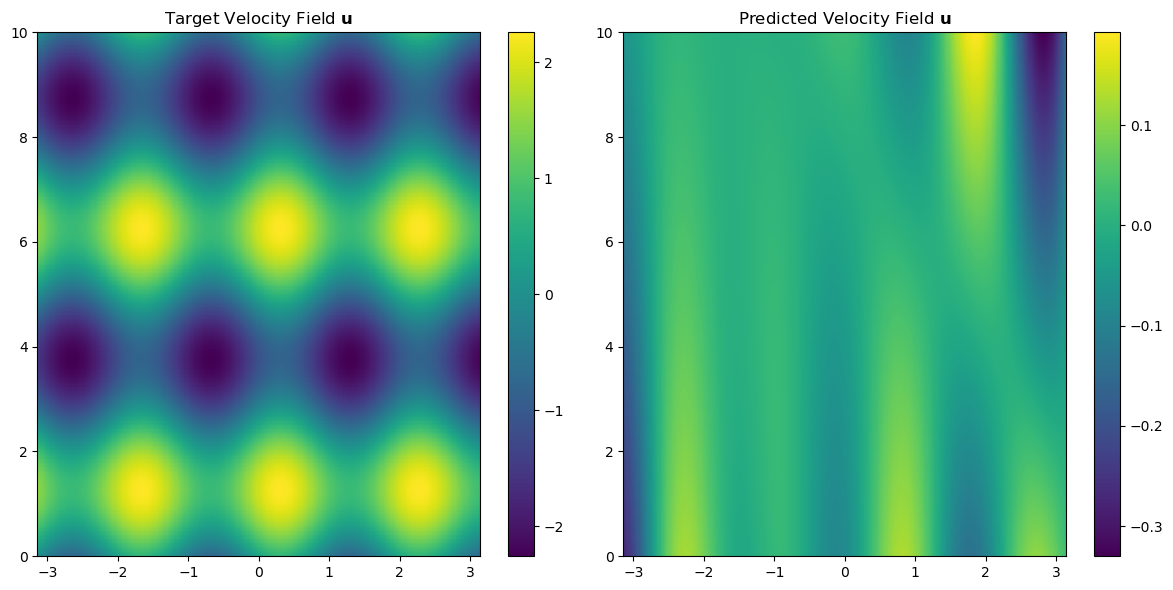

In [6]:
print("Starting SGD Optimization...")
sgd_optimization(shared_test_data)


Starting Machine Learning Optimization...
Epoch 0, Loss: 0.14711253345012665
Test Mean Squared Error: 0.001409213407896459
Test Mean Absolute Error: 0.028058793395757675
Test R^2 Score: 0.99861741065979


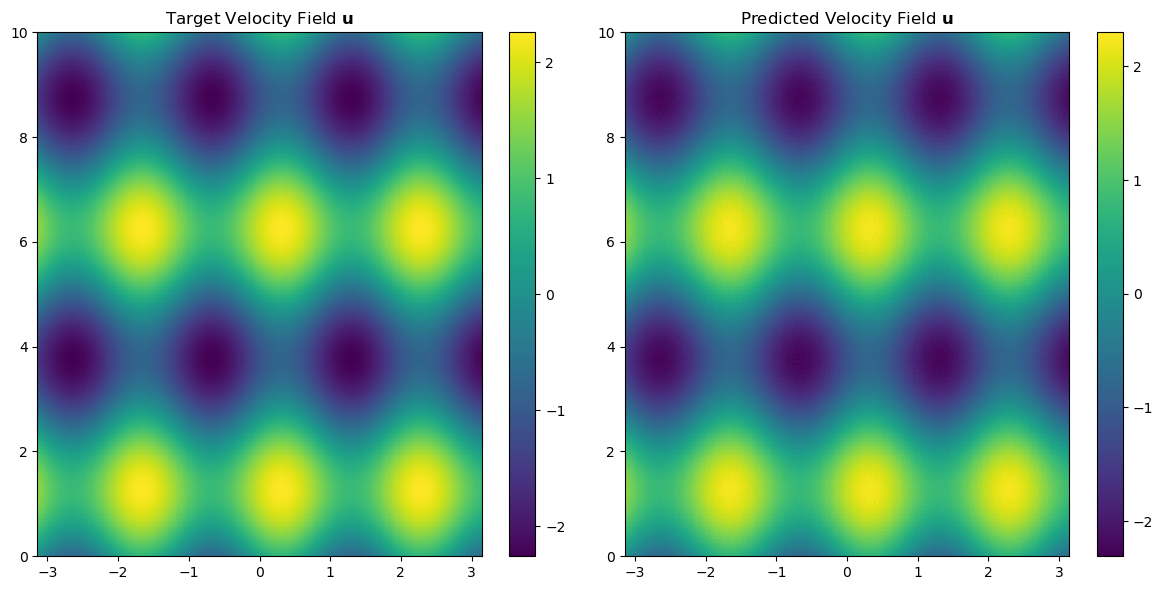

In [7]:
print("\nStarting Machine Learning Optimization...")
machine_learning_optimization(shared_train_data, shared_test_data)

In [45]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

def generate_data(num_samples, size):
    x = np.linspace(-np.pi, np.pi, size)
    t = np.linspace(0, 10, size)
    X, T = np.meshgrid(x, t, indexing='ij')
    data = []
    for _ in range(num_samples):
        a = np.random.randn()
        b = np.random.randn()
        c = np.random.randn()
        d = np.random.randn()
        u = a * np.sin(X - T) * np.cos(X + T) - b * np.cos(X - T) * np.sin(X + T) + c * np.sin(X + T) * np.cos(X - T) - d * np.cos(X + T) * np.sin(X - T)
        data.append((u, (a, b, c, d)))
    return data

# 准备训练和测试数据
num_samples = 2000
size = 10  # 将数据尺寸调整为 10x10
data = generate_data(num_samples, size)
train_data = data[:1000]
test_data = data[1000:]
shared_train_data = train_data
shared_test_data = test_data


In [46]:
class VelocityDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        u, params = self.data[idx]
        return torch.tensor(u, dtype=torch.float32).unsqueeze(0), torch.tensor(params, dtype=torch.float32)

train_dataset = VelocityDataset(shared_train_data)
test_dataset = VelocityDataset(shared_test_data)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [47]:
import torch.nn as nn

class VelocityPredictor(nn.Module):
    def __init__(self):
        super(VelocityPredictor, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 10 * 10, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [52]:
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 初始化模型和优化器
model = VelocityPredictor()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 计算速度场
def compute_velocity(X, T, a, b, c, d):
    a_val = a * torch.sin(X - T)
    b_val = b * torch.cos(X + T)
    c_val = c * torch.sin(X + T)
    d_val = d * torch.cos(X - T)
    return a_val - b_val + c_val - d_val

# 训练模型
# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for u, params in train_loader:
        optimizer.zero_grad()
        outputs = model(u)
        
        # 生成一维张量
        X = torch.linspace(-np.pi, np.pi, size)
        T = torch.linspace(0, 10, size)
        X, T = torch.meshgrid(X, T, indexing='ij')
        
        # 扩展参数维度以匹配 X 和 T
        a = outputs[:, 0].view(-1, 1, 1).expand(-1, size, size)
        b = outputs[:, 1].view(-1, 1, 1).expand(-1, size, size)
        c = outputs[:, 2].view(-1, 1, 1).expand(-1, size, size)
        d = outputs[:, 3].view(-1, 1, 1).expand(-1, size, size)
        
        u_pred = compute_velocity(X, T, a, b, c, d)
        loss = criterion(u_pred, u.squeeze(1))
        loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

model.eval()
with torch.no_grad():
    test_targets = []
    test_predictions = []
    for u, params in test_loader:
        outputs = model(u)
        
        # 生成一维张量
        X = torch.linspace(-np.pi, np.pi, size)
        T = torch.linspace(0, 10, size)
        X, T = torch.meshgrid(X, T, indexing='ij')
        
        # 扩展参数维度以匹配 X 和 T
        a = outputs[:, 0].view(-1, 1, 1).expand(-1, size, size)
        b = outputs[:, 1].view(-1, 1, 1).expand(-1, size, size)
        c = outputs[:, 2].view(-1, 1, 1).expand(-1, size, size)
        d = outputs[:, 3].view(-1, 1, 1).expand(-1, size, size)
        
        u_pred = compute_velocity(X, T, a, b, c, d)
        test_targets.append(u.numpy())
        test_predictions.append(u_pred.numpy())

    test_targets = np.concatenate(test_targets)
    test_predictions = np.concatenate(test_predictions)

    mse = mean_squared_error(test_targets.flatten(), test_predictions.flatten())
    mae = mean_absolute_error(test_targets.flatten(), test_predictions.flatten())
    r2 = r2_score(test_targets.flatten(), test_predictions.flatten())

    print(f'Test Mean Squared Error: {mse}')
    print(f'Test Mean Absolute Error: {mae}')
    print(f'Test R^2 Score: {r2}')





Epoch 1/10, Loss: 0.9937872886657715
Epoch 2/10, Loss: 0.8209601044654846
Epoch 3/10, Loss: 0.8164185285568237
Epoch 4/10, Loss: 1.3566884994506836
Epoch 5/10, Loss: 1.4172413349151611
Epoch 6/10, Loss: 0.9194235801696777
Epoch 7/10, Loss: 1.1205662488937378
Epoch 8/10, Loss: 0.6032686233520508
Epoch 9/10, Loss: 0.7233464121818542
Epoch 10/10, Loss: 1.021589756011963
Test Mean Squared Error: 0.9258347749710083
Test Mean Absolute Error: 0.7263146638870239
Test R^2 Score: 0.00014400482177734375


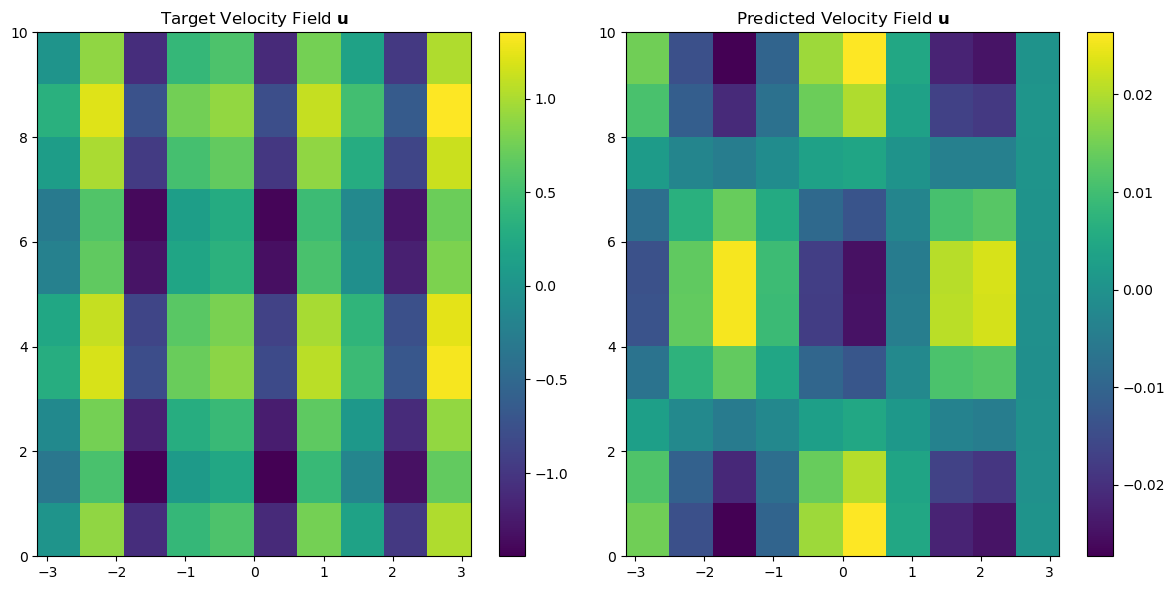

In [54]:
# 可视化结果
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(test_targets[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Target Velocity Field $\\mathbf{u}$')

plt.subplot(1, 2, 2)
plt.imshow(test_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Predicted Velocity Field $\\mathbf{u}$')

plt.tight_layout()
plt.show()


In [65]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

def generate_data(num_samples, size):
    x = np.linspace(-np.pi, np.pi, size)
    t = np.linspace(0, 10, size)
    X, T = np.meshgrid(x, t, indexing='ij')
    data = []
    for _ in range(num_samples):
        a = np.random.randn(size, size)
        b = np.random.randn(size, size)
        c = np.random.randn(size, size)
        d = np.random.randn(size, size)
        u = a * np.sin(X - T) * np.cos(X + T) - b * np.cos(X - T) * np.sin(X + T) + c * np.sin(X + T) * np.cos(X - T) - d * np.cos(X + T) * np.sin(X - T)
        data.append((u, np.stack((a, b, c, d), axis=0)))
    return data

# 准备训练和测试数据
num_samples = 2000
size = 10  # 将数据尺寸调整为 10x10
data = generate_data(num_samples, size)
train_data = data[:1000]
test_data = data[1000:]
shared_train_data = train_data
shared_test_data = test_data


In [66]:
class VelocityDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        u, params = self.data[idx]
        return torch.tensor(u, dtype=torch.float32).unsqueeze(0), torch.tensor(params, dtype=torch.float32)

train_dataset = VelocityDataset(shared_train_data)
test_dataset = VelocityDataset(shared_test_data)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [67]:
import torch.nn as nn

class VelocityPredictor(nn.Module):
    def __init__(self):
        super(VelocityPredictor, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 10 * 10, 512)
        self.fc2 = nn.Linear(512, 4 * 10 * 10)  # 输出维度为4 * 10 * 10

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 4, 10, 10)  # 调整输出维度
        return x


In [68]:
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 初始化模型和优化器
model = VelocityPredictor()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 计算速度场
def compute_velocity(X, T, a, b, c, d):
    a_val = a * torch.sin(X - T)
    b_val = b * torch.cos(X + T)
    c_val = c * torch.sin(X + T)
    d_val = d * torch.cos(X - T)
    return a_val - b_val + c_val - d_val

# 训练模型
num_epochs = 10
size = 10
for epoch in range(num_epochs):
    model.train()
    for u, params in train_loader:
        optimizer.zero_grad()
        outputs = model(u)
        
        # 生成一维张量
        X = torch.linspace(-np.pi, np.pi, size)
        T = torch.linspace(0, 10, size)
        X, T = torch.meshgrid(X, T, indexing='ij')
        
        # 获取参数
        a = outputs[:, 0, :, :]
        b = outputs[:, 1, :, :]
        c = outputs[:, 2, :, :]
        d = outputs[:, 3, :, :]
        
        u_pred = compute_velocity(X, T, a, b, c, d)
        loss = criterion(u_pred, u.squeeze(1))
        loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 1/10, Loss: 0.39998888969421387
Epoch 2/10, Loss: 0.09447168558835983
Epoch 3/10, Loss: 0.04612195864319801
Epoch 4/10, Loss: 0.027823004871606827
Epoch 5/10, Loss: 0.021256862208247185
Epoch 6/10, Loss: 0.014818629249930382
Epoch 7/10, Loss: 0.01522529125213623
Epoch 8/10, Loss: 0.014219827950000763
Epoch 9/10, Loss: 0.010795085690915585
Epoch 10/10, Loss: 0.009952773340046406


In [69]:
# 测试模型
model.eval()
with torch.no_grad():
    test_targets = []
    test_predictions = []
    for u, params in test_loader:
        outputs = model(u)
        
        # 生成一维张量
        X = torch.linspace(-np.pi, np.pi, size)
        T = torch.linspace(0, 10, size)
        X, T = torch.meshgrid(X, T, indexing='ij')
        
        # 获取参数
        a = outputs[:, 0, :, :]
        b = outputs[:, 1, :, :]
        c = outputs[:, 2, :, :]
        d = outputs[:, 3, :, :]
        
        u_pred = compute_velocity(X, T, a, b, c, d)
        test_targets.append(u.numpy())
        test_predictions.append(u_pred.numpy())

    test_targets = np.concatenate(test_targets)
    test_predictions = np.concatenate(test_predictions)

    mse = mean_squared_error(test_targets.flatten(), test_predictions.flatten())
    mae = mean_absolute_error(test_targets.flatten(), test_predictions.flatten())
    r2 = r2_score(test_targets.flatten(), test_predictions.flatten())

    print(f'Test Mean Squared Error: {mse}')
    print(f'Test Mean Absolute Error: {mae}')
    print(f'Test R^2 Score: {r2}')


Test Mean Squared Error: 0.02002761885523796
Test Mean Absolute Error: 0.11076082289218903
Test R^2 Score: 0.9791032075881958


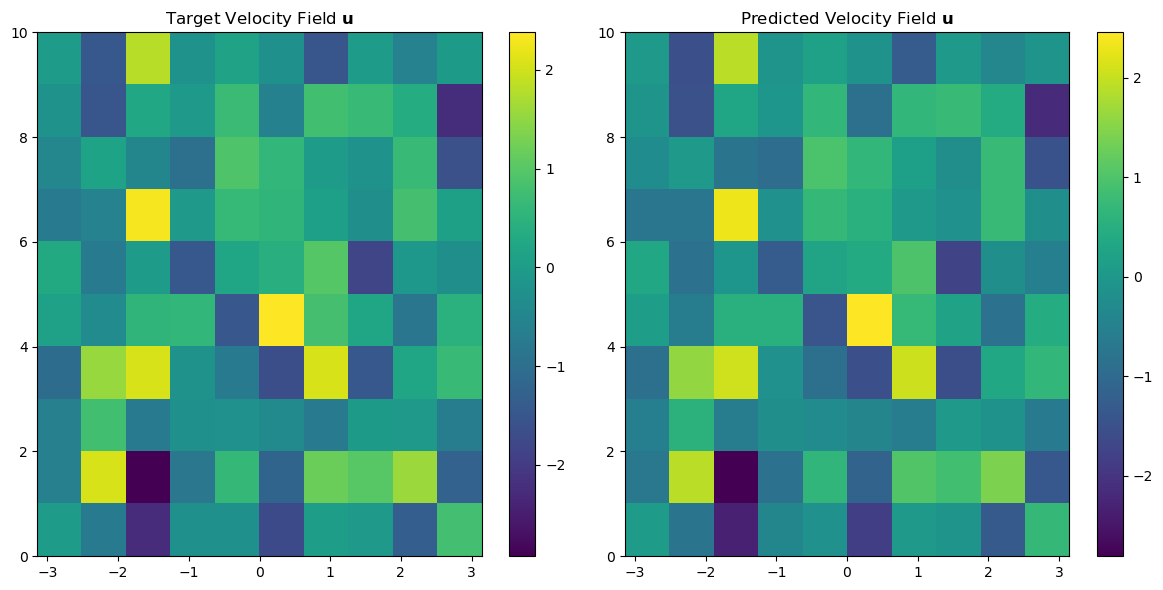

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(test_targets[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Target Velocity Field $\\mathbf{u}$')

plt.subplot(1, 2, 2)
plt.imshow(test_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Predicted Velocity Field $\\mathbf{u}$')

plt.tight_layout()
plt.show()

Epoch 1/10, Loss: 0.30045071244239807
Epoch 2/10, Loss: 0.08127135038375854
Epoch 3/10, Loss: 0.040950991213321686
Epoch 4/10, Loss: 0.030952226370573044
Epoch 5/10, Loss: 0.018588604405522346
Epoch 6/10, Loss: 0.019034523516893387
Epoch 7/10, Loss: 0.013846424408257008
Epoch 8/10, Loss: 0.011861393228173256
Epoch 9/10, Loss: 0.008775574155151844
Epoch 10/10, Loss: 0.009324866347014904
Test Mean Squared Error: 0.021498501300811768
Test Mean Absolute Error: 0.11526524275541306
Test R^2 Score: 0.9774346351623535


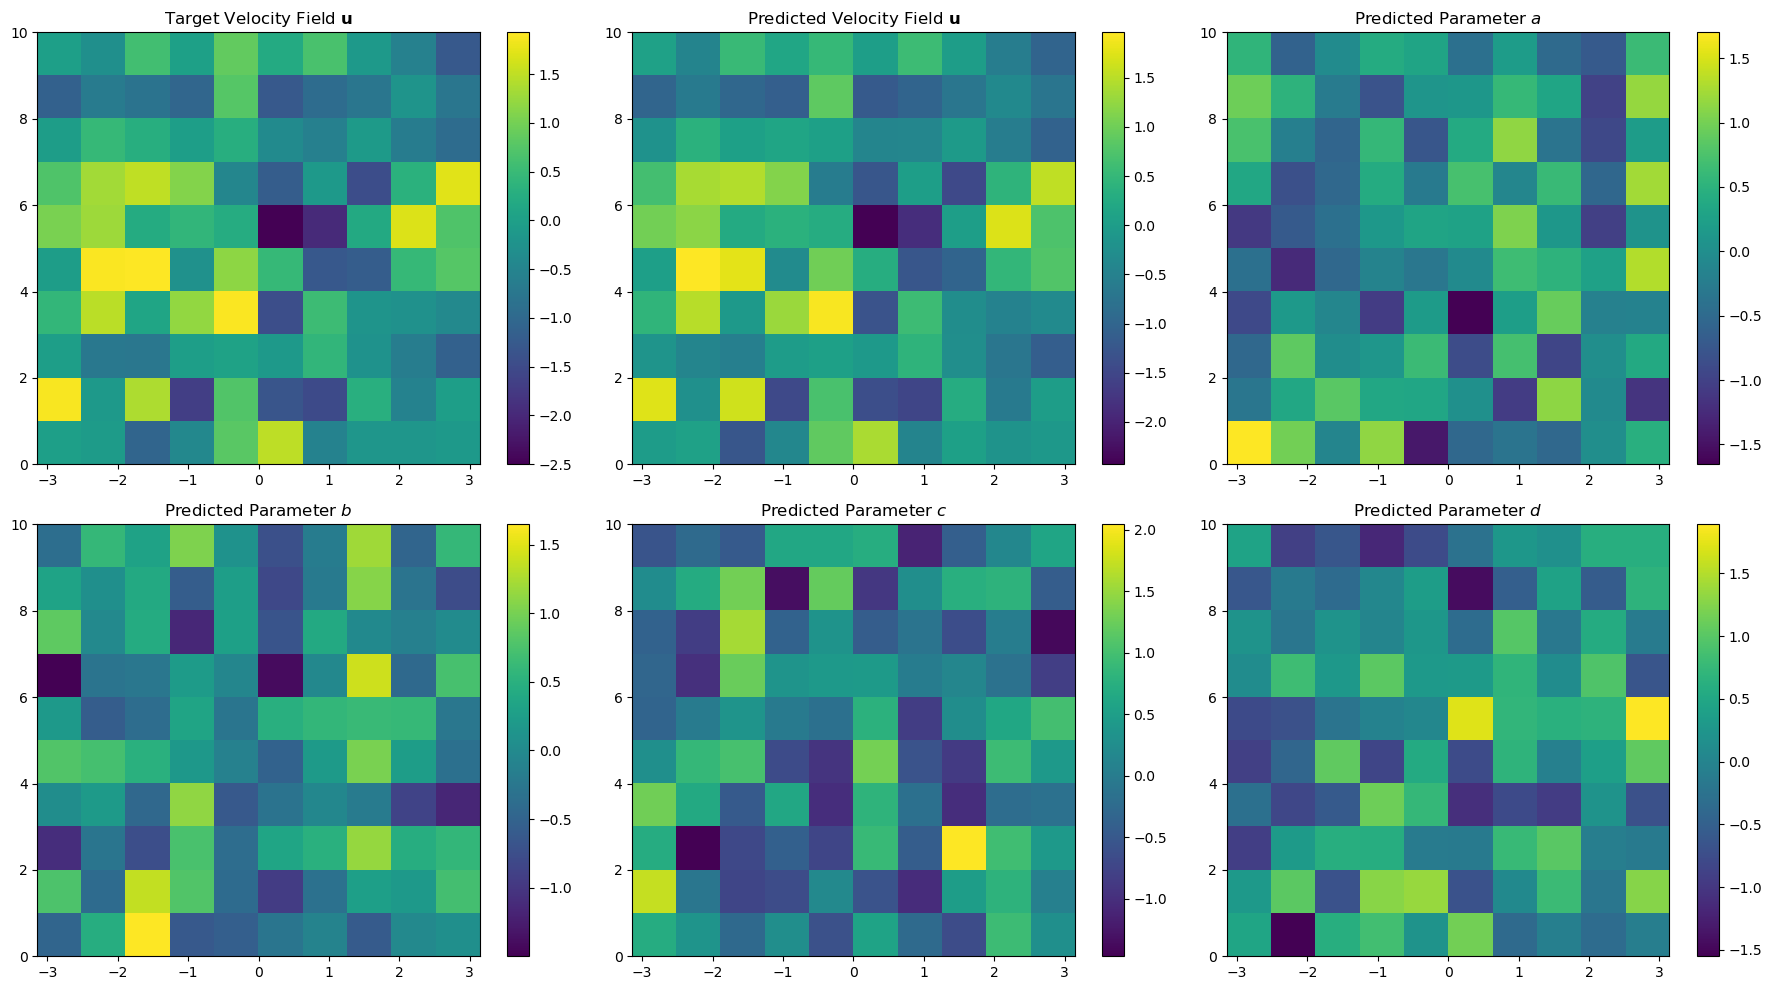

In [72]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 生成数据
def generate_data(num_samples, size):
    x = np.linspace(-np.pi, np.pi, size)
    t = np.linspace(0, 10, size)
    X, T = np.meshgrid(x, t, indexing='ij')
    data = []
    for _ in range(num_samples):
        a = np.random.randn(size, size)
        b = np.random.randn(size, size)
        c = np.random.randn(size, size)
        d = np.random.randn(size, size)
        u = a * np.sin(X - T) * np.cos(X + T) - b * np.cos(X - T) * np.sin(X + T) + c * np.sin(X + T) * np.cos(X - T) - d * np.cos(X + T) * np.sin(X - T)
        data.append((u, np.stack((a, b, c, d), axis=0)))
    return data

# 准备训练和测试数据
num_samples = 2000
size = 10  # 将数据尺寸调整为 10x10
data = generate_data(num_samples, size)
train_data = data[:1000]
test_data = data[1000:]
shared_train_data = train_data
shared_test_data = test_data

# 自定义数据集
class VelocityDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        u, params = self.data[idx]
        return torch.tensor(u, dtype=torch.float32).unsqueeze(0), torch.tensor(params, dtype=torch.float32)

train_dataset = VelocityDataset(shared_train_data)
test_dataset = VelocityDataset(shared_test_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# 模型定义
class VelocityPredictor(nn.Module):
    def __init__(self):
        super(VelocityPredictor, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 10 * 10, 512)
        self.fc2 = nn.Linear(512, 4 * 10 * 10)  # 输出维度为4 * 10 * 10

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 4, 10, 10)  # 调整输出维度
        return x

# 训练与测试
# 初始化模型和优化器
model = VelocityPredictor()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 计算速度场
def compute_velocity(X, T, a, b, c, d):
    a_val = a * torch.sin(X - T)
    b_val = b * torch.cos(X + T)
    c_val = c * torch.sin(X + T)
    d_val = d * torch.cos(X - T)
    return a_val - b_val + c_val - d_val

# 训练模型
num_epochs = 10
size = 10
for epoch in range(num_epochs):
    model.train()
    for u, params in train_loader:
        optimizer.zero_grad()
        outputs = model(u)
        
        # 生成一维张量
        X = torch.linspace(-np.pi, np.pi, size)
        T = torch.linspace(0, 10, size)
        X, T = torch.meshgrid(X, T, indexing='ij')
        
        # 获取参数
        a = outputs[:, 0, :, :]
        b = outputs[:, 1, :, :]
        c = outputs[:, 2, :, :]
        d = outputs[:, 3, :, :]
        
        u_pred = compute_velocity(X, T, a, b, c, d)
        loss = criterion(u_pred, u.squeeze(1))
        loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# 测试模型
model.eval()
with torch.no_grad():
    test_targets = []
    test_predictions = []
    a_predictions = []
    b_predictions = []
    c_predictions = []
    d_predictions = []
    
    for u, params in test_loader:
        outputs = model(u)
        
        # 生成一维张量
        X = torch.linspace(-np.pi, np.pi, size)
        T = torch.linspace(0, 10, size)
        X, T = torch.meshgrid(X, T, indexing='ij')
        
        # 获取参数
        a = outputs[:, 0, :, :]
        b = outputs[:, 1, :, :]
        c = outputs[:, 2, :, :]
        d = outputs[:, 3, :, :]
        
        u_pred = compute_velocity(X, T, a, b, c, d)
        test_targets.append(u.numpy())
        test_predictions.append(u_pred.numpy())
        
        a_predictions.append(a.numpy())
        b_predictions.append(b.numpy())
        c_predictions.append(c.numpy())
        d_predictions.append(d.numpy())

    test_targets = np.concatenate(test_targets)
    test_predictions = np.concatenate(test_predictions)
    a_predictions = np.concatenate(a_predictions)
    b_predictions = np.concatenate(b_predictions)
    c_predictions = np.concatenate(c_predictions)
    d_predictions = np.concatenate(d_predictions)

    mse = mean_squared_error(test_targets.flatten(), test_predictions.flatten())
    mae = mean_absolute_error(test_targets.flatten(), test_predictions.flatten())
    r2 = r2_score(test_targets.flatten(), test_predictions.flatten())

    print(f'Test Mean Squared Error: {mse}')
    print(f'Test Mean Absolute Error: {mae}')
    print(f'Test R^2 Score: {r2}')

# 可视化结果
plt.figure(figsize=(18, 10))

# 绘制目标速度场
plt.subplot(2, 3, 1)
plt.imshow(test_targets[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Target Velocity Field $\\mathbf{u}$')

# 绘制预测速度场
plt.subplot(2, 3, 2)
plt.imshow(test_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Predicted Velocity Field $\\mathbf{u}$')

# 绘制参数a
plt.subplot(2, 3, 3)
plt.imshow(a_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Predicted Parameter $a$')

# 绘制参数b
plt.subplot(2, 3, 4)
plt.imshow(b_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Predicted Parameter $b$')

# 绘制参数c
plt.subplot(2, 3, 5)
plt.imshow(c_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Predicted Parameter $c$')

# 绘制参数d
plt.subplot(2, 3, 6)
plt.imshow(d_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Predicted Parameter $d$')

plt.tight_layout()
plt.show()


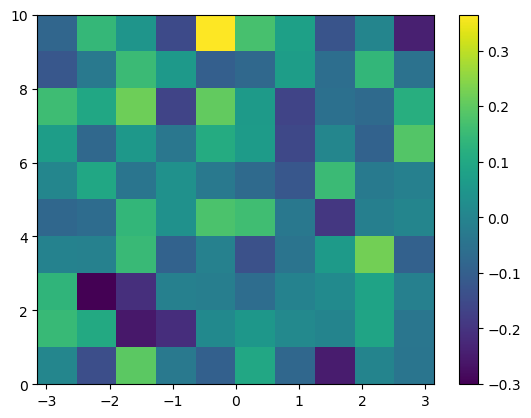

In [74]:
plt.imshow(test_targets[0].squeeze()-test_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()

In [85]:
test_targets[0].squeeze()[5,1],test_predictions[0].squeeze()[5,1]

(1.8956549, 1.9602706)

In [82]:
s1=test_targets[0].squeeze().copy()
s2 = test_predictions[0].squeeze().copy()

In [86]:
s=s1-s2
s[5,1]

-0.06461573

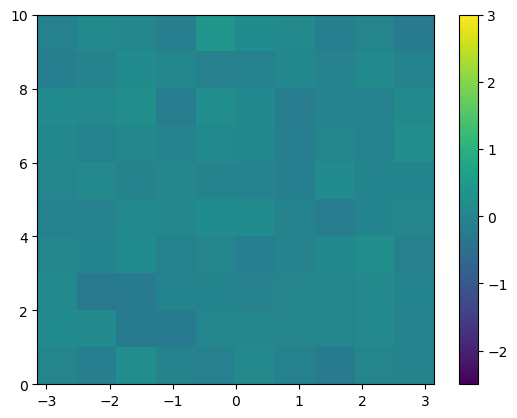

In [92]:
plt.imshow(s, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest', vmin=-2.5, vmax=3)#设置colorbar，从-0.1到0.1
plt.colorbar()